In [115]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from to_plot import plot_ball_timeseries
from scipy.signal import savgol_filter
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks



In [17]:
df=pd.read_json("data/ball_data_79.json")
df=df.T
#let's not consider the frames where the ball is not detected (not visible)
print("Initial number of frames:",df.shape)
df=df[df['visible']==1]
print("Number of frames with ball visible:",df.shape)

Initial number of frames: (205, 4)
Number of frames with ball visible: (112, 4)


In [117]:
df=pd.read_csv('full_data_preprocessed.csv',index_col=0)
df

,x,y,action,filename,x_smooth,y_smooth,cosine_sim,speed_delta,y_distortion,x_distortion,...,y_diff,x_diff,dist_to_event,vx,vy,speed,ax,ay,jerk_mag,turn_angle_deg
324564,849.0,257.0,air,data/ball_data_115.json,849.000000,257.000000,1.000000,27.073973,1.0,1.0,...,-1.133333,21.200000,12,10.0,-200.0,200.249844,-5.115908e-11,-1.500000e+02,0.000000,0.000000
324565,850.0,251.0,air,data/ball_data_115.json,849.333333,250.333333,0.999389,20.260403,1.0,1.0,...,-1.442857,27.095238,11,10.0,-205.0,205.243758,-2.557954e-11,-1.500000e+02,-1125.000000,0.070166
324566,849.0,243.0,air,data/ball_data_115.json,849.666667,243.333333,0.999764,8.037516,1.0,1.0,...,-1.545238,28.602381,10,10.0,-210.0,210.237960,7.500000e+01,-6.394885e-12,4500.000000,0.066866
324567,850.0,236.0,air,data/ball_data_115.json,850.000000,236.333333,0.999993,-3.653257,1.0,1.0,...,-1.920635,29.984127,9,15.0,-205.0,205.548048,0.000000e+00,4.500000e+02,13884.372072,1.458627
324568,851.0,230.0,air,data/ball_data_115.json,850.666667,229.666667,0.987649,-9.071733,1.0,1.0,...,-2.669048,31.445238,8,10.0,-180.0,180.277564,-2.250000e+02,9.750000e+02,6936.215693,1.005120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655760,1024.0,401.0,air,data/ball_data_246.json,1024.000000,401.333333,0.903649,-2.509402,1.0,1.0,...,5.285714,16.485714,16,-20.0,-95.0,97.082439,2.557954e-11,3.000000e+02,4056.245185,1.503882
655761,1023.0,398.0,air,data/ball_data_246.json,1023.333333,398.333333,0.838279,-4.119038,1.0,1.0,...,4.380952,12.571429,17,-25.0,-85.0,88.600226,-4.500000e+02,3.000000e+02,11607.548696,4.500898
655762,1023.0,396.0,air,data/ball_data_246.json,1022.333333,395.666667,0.783668,-4.479658,1.0,1.0,...,3.628571,8.990476,18,-50.0,-75.0,90.138782,-1.050000e+03,2.250000e+02,7677.637084,17.300531
655763,1021.0,393.0,air,data/ball_data_246.json,1020.000000,393.333333,0.700988,-6.951846,1.0,1.0,...,2.723810,5.704762,19,-95.0,-70.0,118.004237,-1.050000e+03,7.500000e+01,-4857.548696,19.925584


In [119]:
FEATURES=['x_smooth', 'y_smooth', 'cosine_sim',
       'speed_delta', 'y_distortion', 'x_distortion', 'acc_x', 'acc_y',
       'acc_mag', 'y_diff', 'x_diff', 'dist_to_event', 'vx', 'vy', 'speed',
       'ax', 'ay', 'jerk_mag', 'turn_angle_deg']

In [120]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

X = df[FEATURES]
y = df['action']


In [121]:
# --- 2. Data Splitting ---

# A. Step 1: Split off the independent Test Set (e.g., 20% of the total data)
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y  # Important for anomaly detection to maintain the imbalance ratio
)

# B. Step 2: Split the remaining data (80%) into Train and Validation (e.g., 70% Train, 30% Validation)
# Validation set size relative to the original data: 0.8 * 0.375 = 0.3
VAL_SIZE_RELATIVE = 0.375 # This makes the final splits approximately 60% Train, 20% Validation, 20% Test

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE_RELATIVE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_train_val # Maintain imbalance ratio in the split
)

# --- Verification of Splits ---
print("\n--- Data Split Verification ---")
print(f"Train samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


--- Data Split Verification ---
Train samples: 56836 (50.0%)
Validation samples: 34102 (30.0%)
Test samples: 22735 (20.0%)


In [123]:
from sklearn.preprocessing import LabelEncoder
# --- STEP 1: Encode the Target Labels ---
# Initialize the encoder
le = LabelEncoder()

# Fit the encoder on the entire original target series (or just y_train if necessary)
# This maps 'Normal' -> 0, 'Type A' -> 1, 'Type B' -> 2, etc.
# We must use the .values attribute to ensure we're working with numpy arrays
y_train_encoded = le.fit_transform(y_train.values)
y_val_encoded = le.transform(y_val.values)
y_test_encoded = le.transform(y_test.values)

In [124]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
# Assume 'le' (LabelEncoder) is available from previous steps

# --- REQUIRED SETUP (Assuming le, X/y splits, and RANDOM_STATE are defined) ---
# Determine the number of classes from the fitted LabelEncoder
# This is crucial for the 'num_class' parameter.
num_classes = len(le.classes_) 
all_encoded_labels = np.arange(num_classes)
target_names = le.classes_ # Original names for the report

# --- 3. XGBoost Model Training (FIXED) ---

# A. Create DMatrix objects (XGBoost's optimized data structure)
# Ensure you are using the ENCODED labels for DMatrix creation!
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dval = xgb.DMatrix(X_val, label=y_val_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# B. Define Parameters for Multi-Class Classification (FIXED)
params = {
    'objective': 'multi:softmax',       # FIX: Use multi-class objective
    'num_class': num_classes,           # FIX: REQUIRED - must specify number of classes
    'eval_metric': 'mlogloss',          # FIX: Standard metric for multi-class optimization
    'eta': 0.05,
    'max_depth': 5,
    'seed': RANDOM_STATE,
    # FIX: Removed 'scale_pos_weight' as it is invalid for multi-class
    'use_label_encoder': False          # Standard setting
}

# C. Train the Model with Early Stopping (using the Validation set)
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"\nModel trained. Best iteration: {model.best_iteration}")

# --- 4. Final Evaluation on the Test Set (FIXED) ---

# Predict the class index (0, 1, 2, etc.) directly using the 'multi:softmax' objective
y_pred = model.predict(dtest) 

# D. Calculate Key Anomaly Detection Metrics (FIXED for Multi-Class)

# 1. Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)

# 2. Per-Class Metrics (P, R, F1, Support)
# FIX: average=None and provide the full list of labels [0, 1, 2, ...]
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test_encoded, 
    y_pred, 
    average=None, 
    labels=all_encoded_labels, 
    zero_division=0
)

# 3. Comprehensive Report (Best for Multi-Class Evaluation)
class_report = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=all_encoded_labels, 
    target_names=target_names,
    zero_division=0
)

print("\n--- Test Set Performance (Multi-Class) ---")
print(f"Accuracy: {test_accuracy:.4f}")
print("--- Detailed Per-Class Metrics ---")
print("Encoded Labels:", all_encoded_labels)
print("Precision per class:", test_precision)
print("Recall per class:", test_recall)
print("F1-Score per class:", test_f1)
print(f"\nClassification Report:\n{class_report}")

/home/ysidhom/Documents/M2DS/QSA_tennis/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:07:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



Model trained. Best iteration: 403

--- Test Set Performance (Multi-Class) ---
Accuracy: 0.9798
--- Detailed Per-Class Metrics ---
Encoded Labels: [0 1 2]
Precision per class: [0.98591676 0.60538117 0.73148148]
Recall per class: [0.99349182 0.46712803 0.49375   ]
F1-Score per class: [0.98968979 0.52734375 0.58955224]

Classification Report:
              precision    recall  f1-score   support

         air       0.99      0.99      0.99     22126
      bounce       0.61      0.47      0.53       289
         hit       0.73      0.49      0.59       320

    accuracy                           0.98     22735
   macro avg       0.77      0.65      0.70     22735
weighted avg       0.98      0.98      0.98     22735




--- XGBoost Feature Importance (by Gain) ---


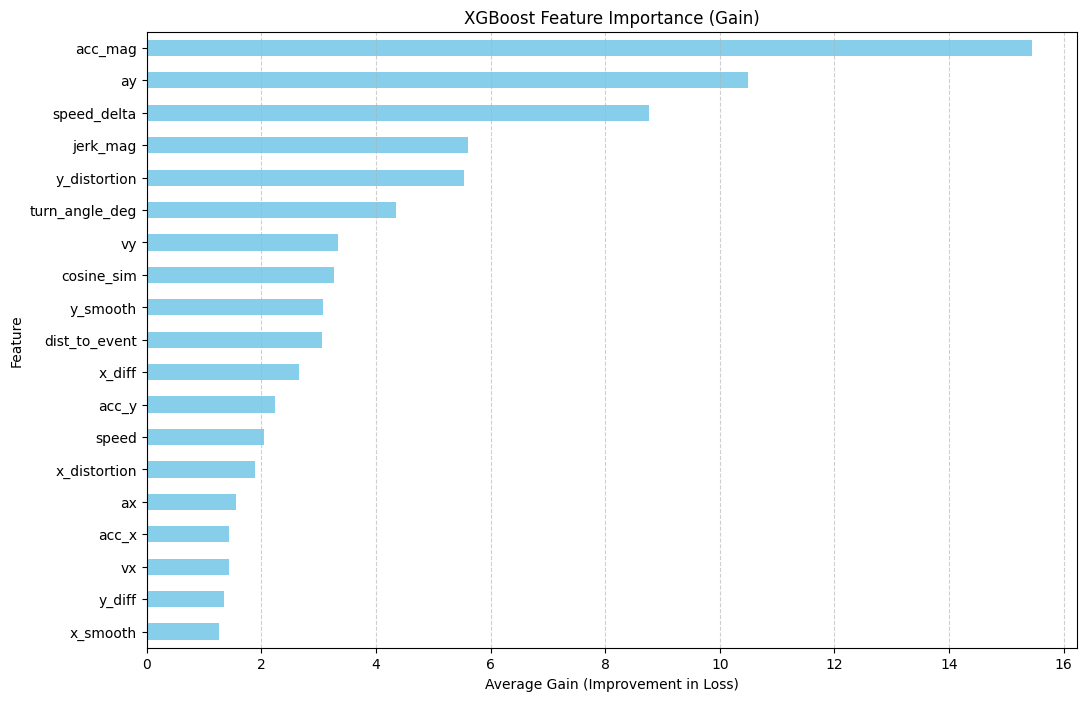

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
# Note: Ensure the trained 'model' object is available

# --- CRITICAL ASSUMPTION ---
# We must use the list of feature names that existed BEFORE X_train became a NumPy array.
# You need to define this list based on the columns you fed into X_train.
# REPLACE THE LIST BELOW WITH YOUR ACTUAL FEATURE NAMES
ORIGINAL_FEATURE_NAMES = FEATURES
# Assuming these names were in the correct order when creating X_train/dtrain.


# --- 1. Get Feature Importance Scores (FIXED for NumPy Input) ---

# Get the importance dictionary (mapping XGBoost names (f0, f1, ...) to scores)
importance_dict = model.get_score(importance_type='gain')

# Convert the importance dictionary to a pandas Series
importance_series = pd.Series(importance_dict).sort_values(ascending=False)

# 1. Create the mapping dictionary: { 'f0': 'Name_A', 'f1': 'Name_B', ... }
# We rely on the order of the features in the NumPy array matching the order of this list.
feature_mapping = {f'f{i}': name for i, name in enumerate(ORIGINAL_FEATURE_NAMES)}

# 2. Apply the mapping to the index of the importance Series

print("\n--- XGBoost Feature Importance (by Gain) ---")



# --- 2. Visualization of Feature Importance ---

plt.figure(figsize=(12, 8))
# Plotting the Series directly
importance_series.plot(kind='barh', color='skyblue')

plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Average Gain (Improvement in Loss)')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [140]:
FEATURES_AFTER=importance_series.index[:13]
FEATURES_AFTER

Index(['acc_mag', 'ay', 'speed_delta', 'jerk_mag', 'y_distortion',
       'turn_angle_deg', 'vy', 'cosine_sim', 'y_smooth', 'dist_to_event',
       'x_diff', 'acc_y', 'speed'],
      dtype='object')

In [141]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

X = df[FEATURES_AFTER]
y = df['action']


In [142]:
# --- 2. Data Splitting ---

# A. Step 1: Split off the independent Test Set (e.g., 20% of the total data)
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y  # Important for anomaly detection to maintain the imbalance ratio
)

# B. Step 2: Split the remaining data (80%) into Train and Validation (e.g., 70% Train, 30% Validation)
# Validation set size relative to the original data: 0.8 * 0.375 = 0.3
VAL_SIZE_RELATIVE = 0.375 # This makes the final splits approximately 60% Train, 20% Validation, 20% Test

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE_RELATIVE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_train_val # Maintain imbalance ratio in the split
)

# --- Verification of Splits ---
print("\n--- Data Split Verification ---")
print(f"Train samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


--- Data Split Verification ---
Train samples: 56836 (50.0%)
Validation samples: 34102 (30.0%)
Test samples: 22735 (20.0%)


In [143]:
from sklearn.preprocessing import LabelEncoder
# --- STEP 1: Encode the Target Labels ---
# Initialize the encoder
le = LabelEncoder()

# Fit the encoder on the entire original target series (or just y_train if necessary)
# This maps 'Normal' -> 0, 'Type A' -> 1, 'Type B' -> 2, etc.
# We must use the .values attribute to ensure we're working with numpy arrays
y_train_encoded = le.fit_transform(y_train.values)
y_val_encoded = le.transform(y_val.values)
y_test_encoded = le.transform(y_test.values)

In [144]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
# Assume 'le' (LabelEncoder) is available from previous steps

# --- REQUIRED SETUP (Assuming le, X/y splits, and RANDOM_STATE are defined) ---
# Determine the number of classes from the fitted LabelEncoder
# This is crucial for the 'num_class' parameter.
num_classes = len(le.classes_) 
all_encoded_labels = np.arange(num_classes)
target_names = le.classes_ # Original names for the report

# --- 3. XGBoost Model Training (FIXED) ---

# A. Create DMatrix objects (XGBoost's optimized data structure)
# Ensure you are using the ENCODED labels for DMatrix creation!
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dval = xgb.DMatrix(X_val, label=y_val_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# B. Define Parameters for Multi-Class Classification (FIXED)
params = {
    'objective': 'multi:softmax',       # FIX: Use multi-class objective
    'num_class': num_classes,           # FIX: REQUIRED - must specify number of classes
    'eval_metric': 'mlogloss',          # FIX: Standard metric for multi-class optimization
    'eta': 0.05,
    'max_depth': 5,
    'seed': RANDOM_STATE,
    # FIX: Removed 'scale_pos_weight' as it is invalid for multi-class
    'use_label_encoder': False          # Standard setting
}

# C. Train the Model with Early Stopping (using the Validation set)
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"\nModel trained. Best iteration: {model.best_iteration}")

# --- 4. Final Evaluation on the Test Set (FIXED) ---

# Predict the class index (0, 1, 2, etc.) directly using the 'multi:softmax' objective
y_pred = model.predict(dtest) 

# D. Calculate Key Anomaly Detection Metrics (FIXED for Multi-Class)

# 1. Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)

# 2. Per-Class Metrics (P, R, F1, Support)
# FIX: average=None and provide the full list of labels [0, 1, 2, ...]
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test_encoded, 
    y_pred, 
    average=None, 
    labels=all_encoded_labels, 
    zero_division=0
)

# 3. Comprehensive Report (Best for Multi-Class Evaluation)
class_report = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=all_encoded_labels, 
    target_names=target_names,
    zero_division=0
)

print("\n--- Test Set Performance (Multi-Class) ---")
print(f"Accuracy: {test_accuracy:.4f}")
print("--- Detailed Per-Class Metrics ---")
print("Encoded Labels:", all_encoded_labels)
print("Precision per class:", test_precision)
print("Recall per class:", test_recall)
print("F1-Score per class:", test_f1)
print(f"\nClassification Report:\n{class_report}")

/home/ysidhom/Documents/M2DS/QSA_tennis/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:12:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



Model trained. Best iteration: 372

--- Test Set Performance (Multi-Class) ---
Accuracy: 0.9792
--- Detailed Per-Class Metrics ---
Encoded Labels: [0 1 2]
Precision per class: [0.98560409 0.58604651 0.72072072]
Recall per class: [0.99326584 0.43598616 0.5       ]
F1-Score per class: [0.98942013 0.5        0.5904059 ]

Classification Report:
              precision    recall  f1-score   support

         air       0.99      0.99      0.99     22126
      bounce       0.59      0.44      0.50       289
         hit       0.72      0.50      0.59       320

    accuracy                           0.98     22735
   macro avg       0.76      0.64      0.69     22735
weighted avg       0.98      0.98      0.98     22735



In [89]:
feature_mapping

{'f0': 'x',
 'f1': 'y',
 'f2': 'x_smooth',
 'f3': 'y_smooth',
 'f4': 'cosine_sim',
 'f5': 'speed_delta',
 'f6': 'y_distortion',
 'f7': 'x_distortion',
 'f8': 'acc_x',
 'f9': 'acc_y',
 'f10': 'acc_mag',
 'f11': 'y_diff',
 'f12': 'x_diff',
 'f13': 'dist_to_event'}

In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

X_bin = df_model
y_bin = df['action']


In [76]:
y_bin = [0 if 'air' in el else 1 for el in y_bin]

In [77]:
# --- 2. Data Splitting ---

# A. Step 1: Split off the independent Test Set (e.g., 20% of the total data)
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_bin, y_bin, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_bin  # Important for anomaly detection to maintain the imbalance ratio
)

# B. Step 2: Split the remaining data (80%) into Train and Validation (e.g., 70% Train, 30% Validation)
# Validation set size relative to the original data: 0.8 * 0.375 = 0.3
VAL_SIZE_RELATIVE = 0.375 # This makes the final splits approximately 60% Train, 20% Validation, 20% Test

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE_RELATIVE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_train_val # Maintain imbalance ratio in the split
)

# --- Verification of Splits ---
print("\n--- Data Split Verification ---")
print(f"Train samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


--- Data Split Verification ---
Train samples: 56836 (50.0%)
Validation samples: 34102 (30.0%)
Test samples: 22735 (20.0%)


In [78]:
from sklearn.preprocessing import LabelEncoder
# --- STEP 1: Encode the Target Labels ---
# Initialize the encoder
le = LabelEncoder()

# Fit the encoder on the entire original target series (or just y_train if necessary)
# This maps 'Normal' -> 0, 'Type A' -> 1, 'Type B' -> 2, etc.
# We must use the .values attribute to ensure we're working with numpy arrays
y_train_encoded = y_train
y_val_encoded = y_val
y_test_encoded = y_test

In [82]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_sample_weight 
# Assume 'le' (LabelEncoder) and X/y splits are available

# --- REQUIRED SETUP (Assuming le, X/y splits, and RANDOM_STATE are defined) ---
num_classes = 2
all_encoded_labels = np.arange(num_classes)
target_names = ['0','1']

# --- A. Pre-Processing: Calculate Sample Weights for Imbalance (CRUCIAL FOR ANOMALY DETECTION) ---
# Calculate weights inversely proportional to class frequencies on the training set
sample_weights = compute_sample_weight(
    class_weight='balanced', # Penalize errors on minority classes more heavily
    y=y_train_encoded
)

# --- 3. XGBoost Model Training (ADAPTED FOR ANOMALY DETECTION) ---

# A. Create DMatrix objects (Passing Sample Weights)
dtrain = xgb.DMatrix(X_train, label=y_train_encoded, weight=sample_weights) # Pass weights here!
dval = xgb.DMatrix(X_val, label=y_val_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# B. Define Parameters for Multi-Class Anomaly Detection
params = {
    'objective': 'multi:softprob',      # FIX: Use softprob to get prediction probabilities
    'num_class': num_classes,           # REQUIRED
    'eval_metric': 'mlogloss',          # Standard metric
    'eta': 0.05,
    'max_depth': 5,
    'seed': RANDOM_STATE,
    'use_label_encoder': False          
}

# C. Train the Model with Early Stopping
# Training remains the same, leveraging the weights passed in the DMatrix.
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"\nModel trained. Best iteration: {model.best_iteration}")

# --- 4. Final Evaluation on the Test Set (ADAPTED) ---

# Predict probabilities: y_pred_proba is a matrix (N_samples, N_classes)
y_pred_proba = model.predict(dtest) 

# Convert probabilities back to class index by taking the argmax (highest probability)
y_pred = np.argmax(y_pred_proba, axis=1) # This is equivalent to 'multi:softmax' output

# D. Calculate Key Anomaly Detection Metrics

# 1. Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)

# 2. Per-Class Metrics (P, R, F1, Support)
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test_encoded, 
    y_pred, 
    average=None, 
    labels=all_encoded_labels, 
    zero_division=0
)

# 3. Comprehensive Report (Best for Multi-Class Evaluation)
class_report = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=all_encoded_labels, 
    target_names=target_names,
    zero_division=0
)

print("\n--- Test Set Performance (Multi-Class Anomaly Detection) ---")
print(f"Accuracy: {test_accuracy:.4f}")
print("--- Detailed Per-Class Metrics ---")
print("Encoded Labels:", all_encoded_labels)
print("Precision per class:", test_precision)
print("Recall per class:", test_recall)
print("F1-Score per class:", test_f1)
print(f"\nClassification Report:\n{class_report}")

/home/ysidhom/Documents/M2DS/QSA_tennis/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:58:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



Model trained. Best iteration: 999

--- Test Set Performance (Multi-Class Anomaly Detection) ---
Accuracy: 0.9635
--- Detailed Per-Class Metrics ---
Encoded Labels: [0 1]
Precision per class: [0.99465787 0.4089404 ]
Recall per class: [0.96773027 0.81116585]
F1-Score per class: [0.98100932 0.54375344]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     22126
           1       0.41      0.81      0.54       609

    accuracy                           0.96     22735
   macro avg       0.70      0.89      0.76     22735
weighted avg       0.98      0.96      0.97     22735



In [81]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score
# Assume 'le' (LabelEncoder) and X/y splits are available

# --- REQUIRED SETUP (Assuming X/y splits, and RANDOM_STATE are defined) ---
# Since num_classes = 2, we are in a binary classification context.
# We assume class 1 is the ANOMALY/POSITIVE class and class 0 is the NORMAL/NEGATIVE class.
num_classes = 2
all_encoded_labels = np.arange(num_classes)
target_names = ['Normal (0)','Anomaly (1)'] # Clearer names for the report

# --- A. Pre-Processing: Calculate Imbalance Weight (CRUCIAL) ---
# FIX: In binary classification, we use scale_pos_weight for efficiency.
# Calculate the ratio of negative samples to positive (anomaly) samples.
scale_pos_weight_value = np.sum(y_train_encoded == 0) / np.sum(y_train_encoded == 1)

# --- 3. XGBoost Model Training (FIXED FOR BINARY) ---

# A. Create DMatrix objects (NO sample weights needed here, using param instead)
dtrain = xgb.DMatrix(X_train, label=y_train_encoded) # Removed: weight=sample_weights
dval = xgb.DMatrix(X_val, label=y_val_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# B. Define Parameters for Binary Imbalanced Anomaly Detection (FIXED)
params = {
    'objective': 'binary:logistic',     # FIX: Use binary objective
    # 'num_class' is not needed for binary
    'eval_metric': 'aucpr',             # FIX: AUC-PR is the best metric for binary imbalance
    'eta': 0.05,
    'max_depth': 5,
    'seed': RANDOM_STATE,
    'scale_pos_weight': 1/scale_pos_weight_value, # FIX: Re-introduced binary imbalance parameter
    'use_label_encoder': False
}

# C. Train the Model with Early Stopping
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=50,
    verbose_eval=False
)

print(f"\nModel trained. Best iteration: {model.best_iteration}")

# --- 4. Final Evaluation on the Test Set (FIXED) ---

# Predict probabilities: y_pred_proba is now a 1D array of P(y=1)
# The output of 'binary:logistic' is a 1D numpy array of probabilities.
y_pred_proba = model.predict(dtest) 

# FIX: Explicitly check and ensure y_pred_proba is a 1D array for roc_auc_score
# If y_pred_proba came out as a (N, 1) matrix, roc_auc_score would fail.
# Use .ravel() just in case the array retains an extra dimension from a previous multi-class setup
if y_pred_proba.ndim > 1:
    y_pred_proba = y_pred_proba.ravel()
    
# Convert probabilities to binary predictions using a threshold
THRESHOLD = 0.5 
y_pred = (y_pred_proba > THRESHOLD).astype(int) 

# D. Calculate Key Anomaly Detection Metrics

# 1. Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)

# 2. Per-Class Metrics (P, R, F1, Support)
test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(
    y_test_encoded, 
    y_pred, 
    average=None, 
    labels=all_encoded_labels, 
    zero_division=0
)

# 3. Comprehensive Report (Best for Evaluation)
class_report = classification_report(
    y_test_encoded, 
    y_pred, 
    labels=all_encoded_labels, 
    target_names=target_names,
    zero_division=0
)

# # 4. AUC-ROC (Standard for binary probability output)
# # This line should now succeed with the explicit 1D array check/conversion
# test_roc_auc = roc_auc_score(y_test_encoded, y_pred_proba) 

# print("\n--- Test Set Performance (Binary Anomaly Detection) ---")
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"ROC-AUC: {test_roc_auc:.4f}")
print("--- Detailed Per-Class Metrics ---")
print("Encoded Labels:", all_encoded_labels)
print("Precision per class:", test_precision)
print("Recall per class:", test_recall)
print("F1-Score per class:", test_f1)
print(f"\nClassification Report:\n{class_report}")

/tmp/ipykernel_197364/1169791291.py:16: RuntimeWarning: invalid value encountered in scalar divide
  scale_pos_weight_value = np.sum(y_train_encoded == 0) / np.sum(y_train_encoded == 1)
/home/ysidhom/Documents/M2DS/QSA_tennis/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:55:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



Model trained. Best iteration: 0
--- Detailed Per-Class Metrics ---
Encoded Labels: [0 1]
Precision per class: [0.97321311 0.        ]
Recall per class: [1. 0.]
F1-Score per class: [0.98642473 0.        ]

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.97      1.00      0.99     22126
 Anomaly (1)       0.00      0.00      0.00       609

    accuracy                           0.97     22735
   macro avg       0.49      0.50      0.49     22735
weighted avg       0.95      0.97      0.96     22735

